# Scope
The aim of this file is to outline some results of the experiment concerning inference from **first-passage time data**. A secondary aim is to gather in one place in an orderly manner my thoughts on some problems related to first-passage times, as they appear in neuroscience, so that hopefully, this file can act as a starting point for a more fine-tuned discussion.

# Data
Hodgkin-Huxley model (*HHm*) has been shown to capture the time-evolution of the neuronal membrane potential very faithfully. We will work with the data generated under the assumption that the *true* neuron follows the dynamics of the *HHm*. We could, of course, work directly with the empirical data, but that has some disadvantages, perhaps most importantly:
- we would be hugely limited with the amount of data that could obtained from a single, stationary regime of a neuron
- once the inference is run, we would have a lot less statistical arsenal to choose from to determine whether our results make any sense

So, we assume that the neuron follows the dynamics of the *HHm*, with **stochastic synaptic input**. More precisely, we have a $6$-dimensional process $X$ that solves the following stochastic differential equation:

$$
\begin{equation}
d X_t =
\left[\begin{matrix}
\frac{1}{C_m}(H(X_t) + I(X_t))\\
\alpha_n(X^{[1]}_t)(1-X^{[2]}_t) - \beta_n(X^{[1]}_t)X^{[2]}_t\\
\alpha_m(X^{[1]}_t)(1-X^{[3]}_t) - \beta_m(X^{[1]}_t)X^{[3]}_t\\
\alpha_h(X^{[1]}_t)(1-X^{[4]}_t) - \beta_h(X^{[1]}_t)X^{[4]}_t\\
\theta_e(\bar{g}_e-X^{[5]}_t)\\
\theta_i(\bar{g}_i-X^{[5]}_t)
\end{matrix}\right] dt + 
\left[\begin{matrix}
0 & 0\\
0 & 0\\
0 & 0\\
0 & 0\\
\sigma_e & 0\\
0 & \sigma_i\\
\end{matrix}\right] dW_t,\quad t\in[0,T],\quad X_0=x_0,
\end{equation}
$$
where $W$ is a $2$-dimensional Wiener process, 
$$
\begin{align}
H(x)&:=\bar{g}_K (x^{[2]})^4(V_K-x^{[1]}) + \bar{g}_{Na} (x^{[3]})^3x^{[4]}(V_{Na}-x^{[1]}) + \bar{g}_l(V_l-x^{[1]}),\\
I(x)&:=\frac{1}{A}\left[x^{[5]}(V_e-x^{[1]}) + x^{[6]}(V_i - x^{[1]})\right],\\
\alpha_n(v)&:=\frac{10-v}{100(e^{1-0.1v}-1)},\\
\beta_n(v)&:=\frac{1}{8}e^{-v/80},\\
\alpha_m(v)&:=\frac{25-v}{10(e^{2.5-0.1v}-1)},\\
\beta_m(v)&:=4e^{-v/18},\\
\alpha_h(v)&:=\frac{7}{100}e^{-v/20},\\
\beta_h(v)&:=\frac{1}{e^{(30-v)/10}+1},
\end{align}
$$
and $C_m, \bar{g}_K, \bar{g}_{Na}, \bar{g}_l, \bar{g}_e, \bar{g}_i, V_K, V_{Na}, V_l, V_e, V_i, A, \theta_e, \theta_i, \sigma_e$ and $\sigma_i$ are the parameters of the model.

### Sidenote
Functions $\alpha_k$, $\beta_k$ $k\in\{n,m,h\}$ have been painstakingly handcrafted by Hodgkin and Huxley, pretty much with a ruler and a pencil. Recently, in *Daly, Aidan C., David J. Gavaghan, Chris Holmes, and Jonathan Cooper. "Hodgkin–Huxley revisited: reparametrization and identifiability analysis of the classic action potential model with approximate Bayesian methods." Royal Society open science 2, no. 12 (2015): 150499.* the authors used ABC to try to find these functions in a more systematic way, but we can of course do much better with MCMC for diffusions... maybe it's worth looking into.

In [6]:
# Let's put the above into code, we start from loading some packages and helper functions
using StaticArrays
using LinearAlgebra, Statistics
using Parameters
using Random
using PyPlot
const 𝕍{N} = SArray{Tuple{N},Float64,1,N} where N

OUT_DIR = joinpath(Base.source_dir(), "output")
include(joinpath("src", "auxiliary", "hodgkin_huxley_model_supporting_functions.jl"))

plot_many_τ_hist

In [8]:
#==============================================================================#
#
#           Hodkin-Huxley model with stochastic synaptic input
#
#==============================================================================#

abstract type HodgkinHuxley end

struct OU_params
    θ::Float64
    μ::Float64
    σ::Float64
end

@with_kw struct HodgkinHuxleySSI <: HodgkinHuxley # SSI: stochastic synaptic input
    # ------------
    # membrane capacitance
    c_m::Float64    = 1.0
    # ------------
    # maximum conductances per unit area:
    g_K::Float64    = 36.0      # for potassium
    g_Na::Float64   = 120.0     # sodium
    g_l::Float64    = 0.3       # and leak

    # ------------
    # equilibrium potentials
    v_K::Float64    = -12.0     # for potassium
    v_Na::Float64   = 115.0     # sodium
    v_l::Float64    = 10.0      # leak
    v_E::Float64    # excitatory synaptic input
    v_I::Float64    # inhibitory synaptic input

    # -----------
    # total membrane area
    membrane_area::Float64  = 1.0

    # ----------
    # parameters of the synaptic input
    E::OU_params # excitatory
    I::OU_params # inhibitory
end

resting_HH = (v0 = 0.0, n0 = 0.3177, m0 = 0.0529, h0 = 0.5961)

function synaptic_current(t, y::𝕍{6}, P::HodgkinHuxleySSI)
    ( y[5]*(P.v_E - y[1]) + y[6]*(P.v_I - y[1]) ) / P.membrane_area
end

function standard_HH_currents(t, y, P::T) where {T<:HodgkinHuxley}
    ( P.g_K * y[2]^4*(P.v_K-y[1])
     + P.g_Na * y[3]^3*y[4]*(P.v_Na-y[1])
     + P.g_l * (P.v_l-y[1]) )
end

drift(y::Float64, p::OU_params) = p.θ*(p.μ-y)

function drift(t, y::𝕍{6}, P::HodgkinHuxleySSI)
    @SVector[(synaptic_current(t, y, P) + standard_HH_currents(t, y, P))/P.c_m,
              α_n(y[1]) * (1-y[2]) - β_n(y[1]) * y[2],
              α_m(y[1]) * (1-y[3]) - β_m(y[1]) * y[3],
              α_h(y[1]) * (1-y[4]) - β_h(y[1]) * y[4],
              drift(y[5], P.E),
              drift(y[6], P.I)]
end

σ(t, y::𝕍{6}, P::HodgkinHuxleySSI) = @SMatrix[ 0.0 0.0;
                                               0.0 0.0;
                                               0.0 0.0;
                                               0.0 0.0;
                                               P.E.σ 0.0;
                                               0.0 P.I.σ ]

function α_n(y::Float64)
    x = 0.1*(10.0 - y)
    0.1*x/(exp(x)-1.0)
end

function α_m(y::Float64)
    x = 0.1*(25.0 - y)
    x/(exp(x)-1.0)
end

α_h(y::Float64) = 0.07*exp(-0.05*y)

β_n(y::Float64) = 0.125*exp(-0.0125*y)

β_m(y::Float64) = 4.0*exp(-y/18.0)

β_h(y::Float64) = 1.0/(exp(3.0-0.1*y)+1.0)

β_h (generic function with 1 method)

## Parametrisation
*A. Destexhe et al. 2001* define 4 biologically sound parametrisations:

In [9]:
#==============================================================================#
#
#         Some parametrisations from A. Destexhe et al. 2001
#
#==============================================================================#

layer_VI = (
    area = 34636.0,
    R_in = 58.9,
    E = OU_params(1.0/2.7, 0.012, 0.003),
    I = OU_params(1.0/10.5, 0.057, 0.0066)
)

layer_III = (
    area = 20321.0,
    R_in = 94.2,
    E = OU_params(1.0/7.8, 0.006, 0.0019),
    I = OU_params(1.0/8.8, 0.044, 0.0069)
)

layer_Va = (
    area = 55017.0,
    R_in = 38.9,
    E = OU_params(1.0/2.6, 0.018, 0.035),
    I = OU_params(1.0/8.0, 0.098, 0.0092)
)

layer_Vb = (
    area = 93265.0,
    R_in = 23.1,
    E = OU_params(1.0/2.8, 0.029, 0.0042),
    I = OU_params(1.0/8.5, 0.16, 0.01)
)

(area = 93265.0, R_in = 23.1, E = OU_params(0.35714285714285715, 0.029, 0.0042), I = OU_params(0.11764705882352941, 0.16, 0.01))

However, for now we will be working with some semi-artificial choice and come back to working with the biologically sound ones later on. To reduce the number of moving pieces by a tiny bit, we define an excitatory synaptic input only:

In [15]:
artificial_excitatory = (
    E = OU_params(1.0/2.0, 0.11, 0.0125),
    I = OU_params(1.0/8.0, 0.0, 0.0),
)

# Pick out a type of the neuron for simulations
neuron = artificial_excitatory

P_HH = HodgkinHuxleySSI(
    v_E = 75.0,
    v_I = 0.0,
    E = neuron.E,
    I = neuron.I
)

HodgkinHuxleySSI
  c_m: Float64 1.0
  g_K: Float64 36.0
  g_Na: Float64 120.0
  g_l: Float64 0.3
  v_K: Float64 -12.0
  v_Na: Float64 115.0
  v_l: Float64 10.0
  v_E: Float64 75.0
  v_I: Float64 0.0
  membrane_area: Float64 1.0
  E: OU_params
  I: OU_params


With the original notation, the chosen parametrisation becomes:
$$
\begin{align}
    C_m &= 1 & A &= 1\\
    \bar{g}_K &= 36 & V_K &= -12\\
    \bar{g}_{Na} &= 120 & V_{Na} &= 115\\
    \bar{g}_l &= 0.3 & V_l &= 10\\
    \bar{g}_e &= 0.11 & V_e &= 75 & \theta_e &= 1/2 & \sigma_e &= 1/80\\
    \bar{g}_i &= 0 & V_i &= 0 & \theta_i &= 1/8 & \sigma_i &= 0\\
\end{align}
$$
We can now simulate some sample paths and visualise them to see what is happening...

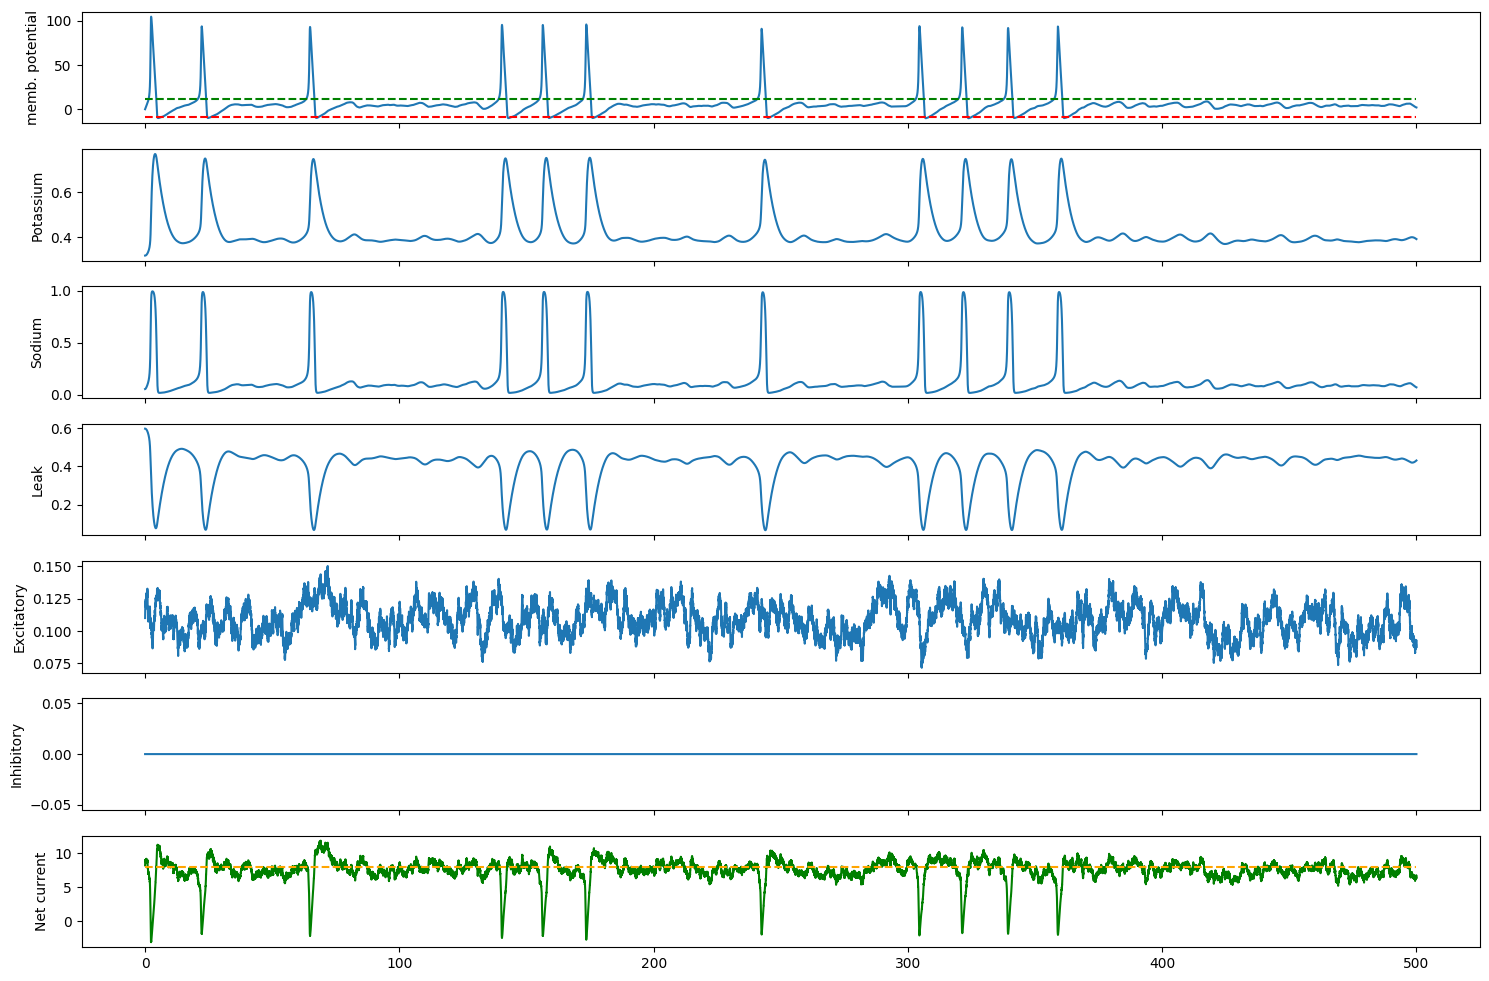

In [20]:
#NOTE functions `_simulate` and `quick_plot` are defined in a companion file
# `hodgkin_huxley_supporting_functions.jl`

T = 500.0
tt = 0.0:0.0001:T
y0 = 𝕍{6}(resting_HH..., neuron.E.μ, neuron.I.μ)
XX = _simulate(𝕍{2}, y0, tt, P_HH)

ax = quick_plot(tt, XX; avg_synaptic_input=8.0)
plt.show()

So the model works... The first coordinate is the membrane potential and we can now impose two artificial levels: spiking threshold and the reset level that together define the first-passage times... Of course, they need to be set to some reasonable levels, but we can do it on some trial-and-error basis.

The last plot illustrates the net current, i.e. $\{I(X_t), t\in[0,T]\}$. Away from spike-times it is fluctuating around $\frac{\bar{g}_e}{A}(V_e-X_{rest}^{[1]})$, and for the ensuing experiments we will assume that this is the value we have control over.

## Data generation
We perform $4$ experiments, where we set the value of $\bar{g}_e$ to different levels across the four experiments. All remaining parameters remain unchanged from those defined above. For each experiment we produce a realisation of the *HHm* and we simply *read off* the first $40$ first-passage times... We start from being a little more generous than we could be in reality, in that we record the time of down-crossing of the reset level $\tau_d$ and the time of up-crossing of the threshold $\tau_u$ and then save $\tau^*:=\tau_u-\tau_d$ as the observed first-passage time. In reality, all we could observe are the times of spikes and so the inter-spike intervals would have been inflated by the refractory period and we would have to manually subtract, say, the mean of the refractory period from the inter-spike intervals---this would introduce additional source of noise. For now, let's keep things simple and deal with actual first-passage times.

In [23]:
#NOTE functions `run_experiment` and `save_τ_to_file` as well as macros
# `τ_summary`, `format_τ` are defined in a companion file
# `hodgkin_huxley_supporting_functions.jl`

Random.seed!(4)

# perform three experiments with various levels of mean excitatory input
data = map([0.08, 0.11, 0.14, 0.17]) do g_E
    neuron = (  # excitatory input only
        E = OU_params(1.0/2.0, g_E, 0.0125),
        I = OU_params(1.0/8.0, 0.0, 0.0),
    )
    P = HodgkinHuxleySSI(
        v_E = 75.0,
        v_I = 0.0,
        E = neuron.E,
        I = neuron.I
    )
    print( "\n***\nStarting the experiment with g_E = $g_E\n",
           "The 'average' synaptic input is: ",
           P.E.μ*(P.v_E-resting_HH[1]), "\n" )

    y0 = 𝕍{6}(resting_HH..., neuron.E.μ, neuron.I.μ)

    sim_parameters = (
        noise_type = 𝕍{2},
        t0 = 0.0,
        x0 = y0,
        reset_lvl = -8.3,
        threshold = 13.0,
        dt = 0.001,
        P = P,
        num_obs = 31,
    )
    @format_τ @τ_summary run_experiment(sim_parameters...)
end

save_τ_to_file(data, joinpath(OUT_DIR, "first_passage_times_hodgkin_huxley.csv"))



***
Starting the experiment with g_E = 0.08
The 'average' synaptic input is: 6.0
------------------------------------------------
mean for ϵ: 3.33, confidence intv: (3.24, 3.42).
------------------------------------------------
reformatting data...

***
Starting the experiment with g_E = 0.11
The 'average' synaptic input is: 8.25
------------------------------------------------
mean for ϵ: 3.36, confidence intv: (3.26, 3.46).
------------------------------------------------
reformatting data...

***
Starting the experiment with g_E = 0.14
The 'average' synaptic input is: 10.500000000000002
------------------------------------------------
mean for ϵ: 3.4, confidence intv: (3.28, 3.52).
------------------------------------------------
reformatting data...

***
Starting the experiment with g_E = 0.17
The 'average' synaptic input is: 12.750000000000002
------------------------------------------------
mean for ϵ: 3.46, confidence intv: (3.29, 3.63).
----------------------------------------

## Some additional observations
The data is ready, but before jumping straight into analysis, let's have a look at the first-passage time distribution under the Hodgkin-Huxley model, because we are in for a surprise...

In [22]:
#==============================================================================#
#
#                   Visualise first-passage time densities
#
#==============================================================================#

#NOTE a function `plot_many_τ_hist` is defined in a companion file
# `hodgkin_huxley_supporting_functions.jl`

τs_HH = map([0.08, 0.11, 0.14, 0.17]) do g_E
    neuron = (  # excitatory input only
        E = OU_params(1.0/2.0, g_E, 0.0125),
        I = OU_params(1.0/8.0, 0.0, 0.0),
    )
    P = HodgkinHuxleySSI(
        v_E = 75.0,
        v_I = 0.0,
        E = neuron.E,
        I = neuron.I
    )
    y0 = 𝕍{6}(resting_HH..., neuron.E.μ, neuron.I.μ)

    sim_parameters = (
        noise_type = 𝕍{2},
        t0 = 0.0,
        x0 = y0,
        reset_lvl = -8.3,
        threshold = 13.0,
        dt = 0.01,
        P = P,
        num_obs = Int64(1e5),
    )
    map(x->x[2]-x[1], @format_τ @τ_summary run_experiment(sim_parameters...))
end

------------------------------------------------
mean for ϵ: 3.35, confidence intv: (-0.3, 7.0).
------------------------------------------------
reformatting data...
------------------------------------------------
mean for ϵ: 3.39, confidence intv: (1.47, 5.31).
------------------------------------------------
reformatting data...
------------------------------------------------
mean for ϵ: 3.42, confidence intv: (2.2, 4.64).
------------------------------------------------
reformatting data...
------------------------------------------------
mean for ϵ: 3.45, confidence intv: (2.48, 4.42).
------------------------------------------------
reformatting data...


4-element Array{Array{Float64,1},1}:
 [273.3899999998915, 16.529999999984966, 15.099999999986267, 15.559999999985848, 23.069999999979018, 50.81999999995378, 14.669999999986658, 15.749999999985675, 125.20999999988618, 43.05999999996084  …  14.67999967187643, 23.099999483674765, 41.97999906167388, 245.50999451242387, 17.26999961398542, 23.26999947987497, 117.48999737389386, 16.019999641925097, 87.33999804779887, 60.78999864123762]    
 [14.150000000000276, 14.750000000000398, 12.239999999997565, 12.730000000001077, 25.400000000012994, 14.260000000007295, 13.370000000000886, 102.74999999990655, 12.469999999988659, 13.429999999987785  …  13.599999696016312, 12.599999718368053, 17.519999608397484, 65.95999852567911, 35.029999217018485, 107.09999760612845, 36.3999991863966, 45.72999897785485, 12.799999713897705, 47.59999893605709]
 [11.279999999999761, 13.150000000001867, 117.92000000000355, 38.6999999999648, 12.59999999998854, 34.199999999968895, 58.21999999994708, 11.539999999989504, 25.34

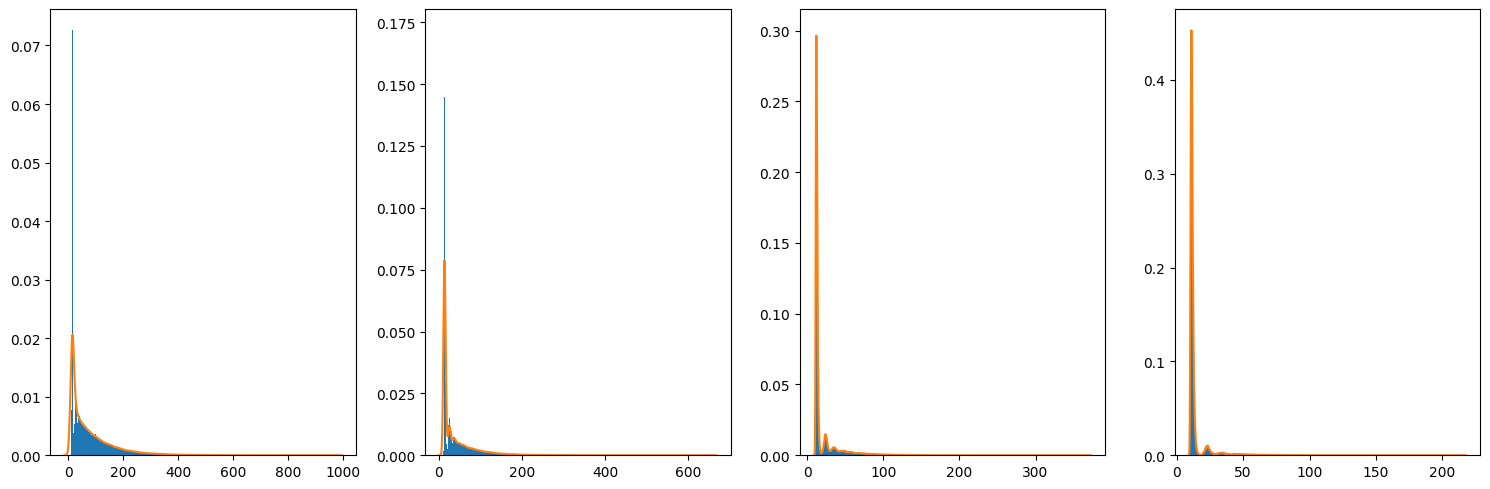

In [24]:
axs = plot_many_τ_hist(τs_HH, nbins=600)
plt.show()

Well... Not much can be scene above... let's zoom in

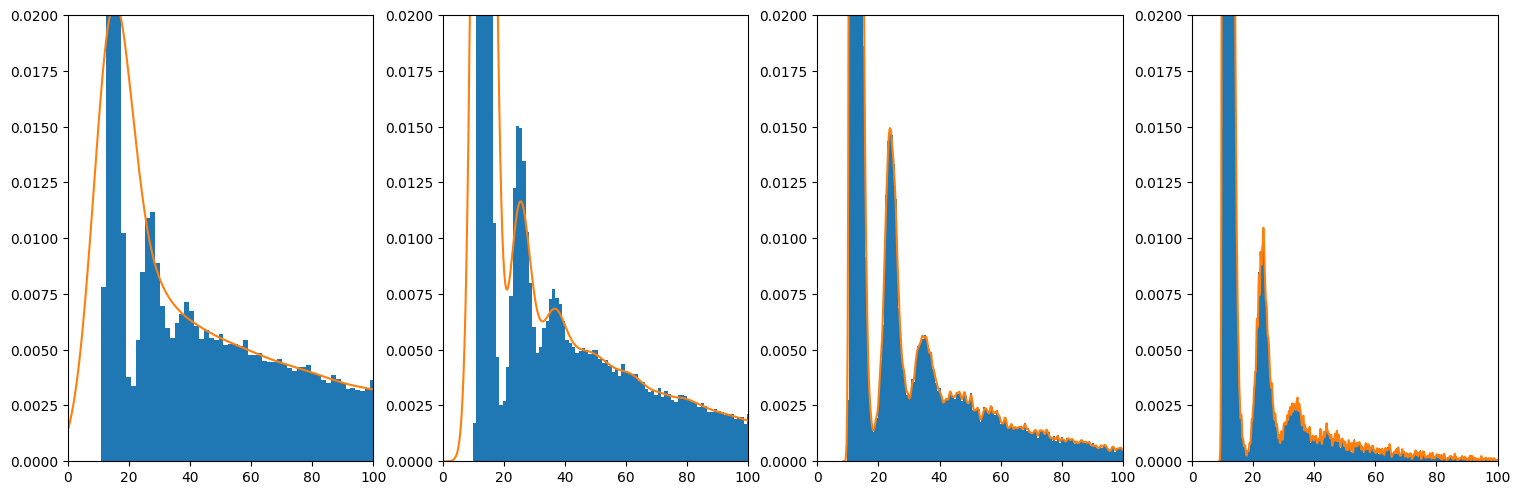

In [25]:
axs = plot_many_τ_hist(τs_HH, nbins=600)
# an interesting zoom-in...
for ax in axs ax.set_ylim([0.0, 0.02]) end
for ax in axs ax.set_xlim([0, 100]) end
plt.show()

I did not expect that... The multimodality is very clearly pronounced! Additionally, there are no spikes that occur prior to time $t\approx 10$... Naturally, there are plenty of questions that follow: is it actually a property of the neuron, that the distribution of the first-passage times is multimodal? I can see how this arises in *HHm* with this sort of noise---without noise the model is deterministic so fpt distribution is just a delta hit at some value (or infinity) and by adding such a tiny level of noise in a peculiar way we get this weird `smoothing effect` of the delta hit that doesn't go entirely according to plan. But is it just a very bad artifact of the stochastic *HHm* (say, akin to how pseudo-random number generators have their sloppy sides) or is it actually something that really manifests itself in the real world? Regardless, of the answer, clearly, this type of data is going to be hugely problematic for the leaky integrate-and-fire (LIF) models.

Equipped with this knowledge, let's press on and try to fit the LIF models nonetheless...

# Inference
Let's start from loading appropriate files, loading the data and preparing it slightly, trimming $40$ observations to $10$ for faster exploration of the results...

In [33]:
include("FirstPassageTimeInference_for_tests.jl")

#------------------------------------------------------------------------------#
#                                Fetch the data
#------------------------------------------------------------------------------#

data = read_τ_data(joinpath(OUT_DIR, "first_passage_times_hodgkin_huxley.csv"))

#------------------------------------------------------------------------------#
#                               Prepare the data
#------------------------------------------------------------------------------#

# trim the data for quicker debugging
data = map(x-> x[1:10], data)

# reformatting
cumulative_trial_lengths = Tuple(cumsum(map(x->x[end][2], data)))
τs = begin
    data_new = [data[1]]
    for (i, y) in enumerate(cumulative_trial_lengths[1:end-1])
        append!(data_new, [map(x->(x[1] + y, x[2] + y), data[1+i])])
    end
    flatten(data_new)
end

Xτs = [(-8.5, 13.0) for _ in τs] # These are the reset levels and thresholds respectively

40-element Array{Tuple{Float64,Float64},1}:
 (-8.5, 13.0)
 (-8.5, 13.0)
 (-8.5, 13.0)
 (-8.5, 13.0)
 (-8.5, 13.0)
 (-8.5, 13.0)
 (-8.5, 13.0)
 (-8.5, 13.0)
 (-8.5, 13.0)
 (-8.5, 13.0)
 (-8.5, 13.0)
 (-8.5, 13.0)
 (-8.5, 13.0)
 ⋮           
 (-8.5, 13.0)
 (-8.5, 13.0)
 (-8.5, 13.0)
 (-8.5, 13.0)
 (-8.5, 13.0)
 (-8.5, 13.0)
 (-8.5, 13.0)
 (-8.5, 13.0)
 (-8.5, 13.0)
 (-8.5, 13.0)
 (-8.5, 13.0)
 (-8.5, 13.0)

## Ornstein-Uhlenbeck process
We start from trying to fit the Ornstein-Uhlenbeck process to our data. More precisely, we assume that between each inter-observation time, the underlying process that generated our data is of the form:

$$
\begin{equation}
d X_t = (\alpha - \theta X_t + I_t)dt + \sigma dW_t,\quad t\in[0,\tau],\quad X_0=x_0,\quad \tau:=\inf\{t\geq 0: X_t\geq L\}.
\end{equation}
$$

We assume that $I_t$ is known under each experiment. In *HHm* with stochastic synaptic input $I_t$ is stochastic, but away from spiking intervals (times which are removed and discarded when using LIF models) $I_t$ is fairly stable and fluctuates around $\frac{\bar{g}_e}{A}(V_e-X_{rest}^{[1]})$. So for the LIF models we set $I_t$ to known constants, corresponding to respective average level of synaptic input in *HHm* under each experiment.

We are ready to run the inference.

In [34]:
#******************************************************************************#
#------------------------------------------------------------------------------#
#                          Run inference on OU process
#------------------------------------------------------------------------------#
#******************************************************************************#

current(t, ::OrnsteinUhlenbeck) = (
    6.0 +
    2.25 * (t <= cumulative_trial_lengths[3]) +
    2.25 * (t <= cumulative_trial_lengths[2]) +
    2.25 * (t <= cumulative_trial_lengths[1])
)
current_prime(t, ::OrnsteinUhlenbeck) = 0.0

P = OrnsteinUhlenbeck(0.1, 1.0, 1.0)

parameters = (
    P = P,
    dt = 0.1,
    num_mcmc_steps = 1000,
    ρ = 0.7,
    updt_param_idx = [1, 3],
    t_kernel = RandomWalk([0.4, 0.2, 0.3], [false, false, true]),
    priors = (
        MvNormal([0.0, 0.0], diagm(0=>[1000.0, 1000.0])),
        ImproperPosPrior(),
        ImproperPosPrior(),
    ),
    update_type = (
        ConjugateUpdate(),
        MetropolisHastings(),
        MetropolisHastings(),
    ),
    save_iter = 100,
    verb_iter = 100,
)

(θs, paths, estim_θ), elapsed = @timeit mcmc(τs, Xτs, parameters...)

* * *
Updating ρs...
[1], ar: 0.4, ρ: 0.7; [2], ar: 0.55, ρ: 0.7; [3], ar: 0.63, ρ: 0.7; [4], ar: 0.42, ρ: 0.7; [5], ar: 0.61, ρ: 0.7; ... (30 ρs are not displayed) ...[36], ar: 0.74, ρ: 0.7; [37], ar: 0.85, ρ: 0.7; [38], ar: 0.82, ρ: 0.7; [39], ar: 0.8, ρ: 0.7; [40], ar: 0.75, ρ: 0.7; 
------------
New ρs: 
[1], ρ: 0.679; [2], ρ: 0.679; [3], ρ: 0.679; [4], ρ: 0.679; [5], ρ: 0.679; ... (30 ρs are not displayed) ...[36], ρ: 0.679; [37], ρ: 0.679; [38], ρ: 0.679; [39], ρ: 0.679; [40], ρ: 0.679; 
------------

it: 100, llᵒ: -249.225, ll: -248.31, llr: -0.915
* * *
Updating ρs...
[1], ar: 0.13, ρ: 0.679; [2], ar: 0.39, ρ: 0.679; [3], ar: 0.81, ρ: 0.679; [4], ar: 0.31, ρ: 0.679; [5], ar: 0.76, ρ: 0.679; ... (30 ρs are not displayed) ...[36], ar: 1.0, ρ: 0.679; [37], ar: 0.95, ρ: 0.679; [38], ar: 0.92, ρ: 0.679; [39], ar: 0.95, ρ: 0.679; [40], ar: 0.97, ρ: 0.679; 
------------
New ρs: 
[1], ρ: 0.7; [2], ρ: 0.656; [3], ρ: 0.656; [4], ρ: 0.656; [5], ρ: 0.656; ... (30 ρs are not displayed) ...[

(output = (Array{Float64,1}[[0.1, 1.0, 1.0], [-0.041063071449542125, -10.807722883860759, 1.0], [-0.041063071449542125, -10.807722883860759, 1.0], [-0.09203841912059413, -10.742542117001207, 1.0], [-0.09203841912059413, -10.742542117001207, 1.0], [-0.11526465708800755, -10.742488936722276, 1.0], [-0.11526465708800755, -10.742488936722276, 1.129551991740258], [-0.1309024435334495, -10.630624104326158, 1.129551991740258], [-0.1309024435334495, -10.630624104326158, 1.129551991740258], [-0.15391401722948353, -10.466422620983284, 1.129551991740258]  …  [0.1960709081504599, -30.117471810365007, 28.328489148950116], [0.1960709081504599, -30.117471810365007, 28.328489148950116], [0.17942297021969766, -27.480435046615398, 28.328489148950116], [0.17942297021969766, -27.480435046615398, 28.328489148950116], [0.16759086801007758, -26.42909310556795, 28.328489148950116], [0.16759086801007758, -26.42909310556795, 28.328489148950116], [0.15969647614879165, -26.024028159876814, 28.328489148950116], [0

Let's examine the results...

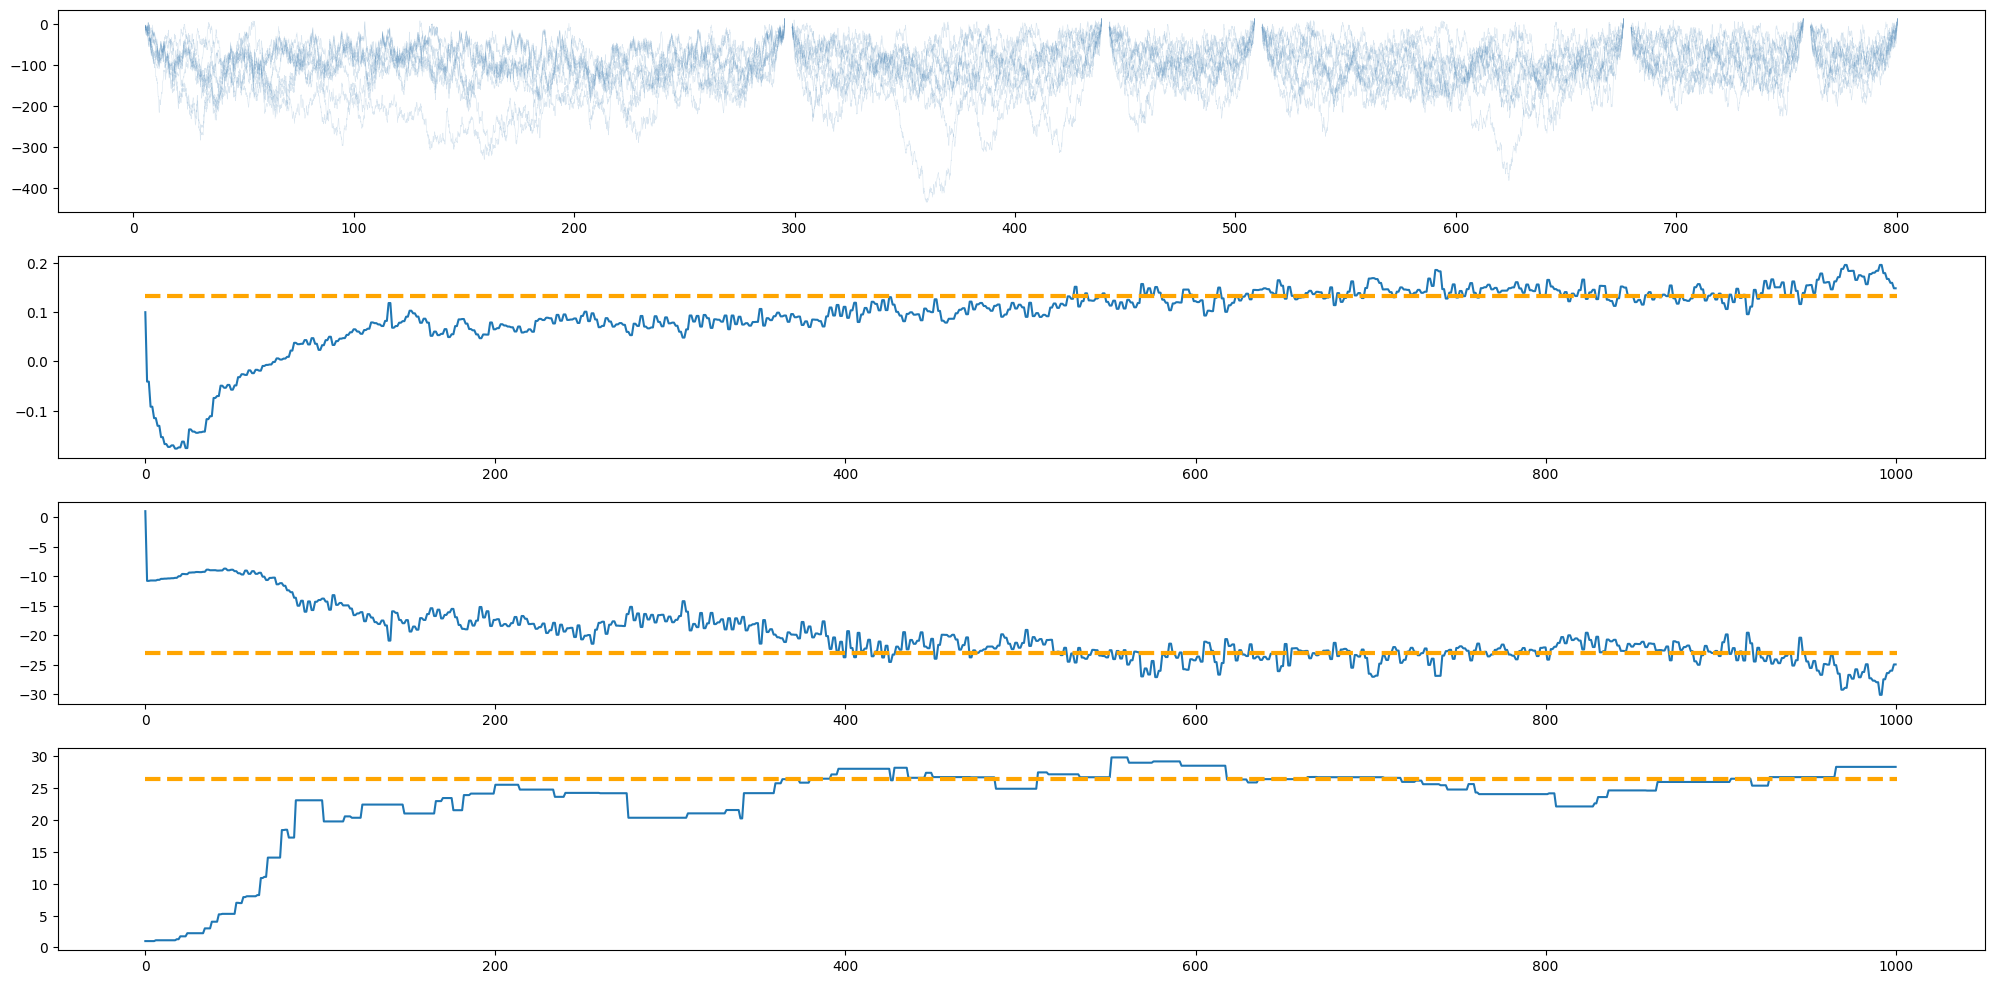

In [35]:
#------------------------------------------------------------------------------#
#                                   SUMMARY
#------------------------------------------------------------------------------#
ax = standard_summary_plot(P, paths, θs, estim_θ)
plt.show()

Ok, so the parameters seem to have been identified... Let's see how the distributions of first-passage times fit the reality...

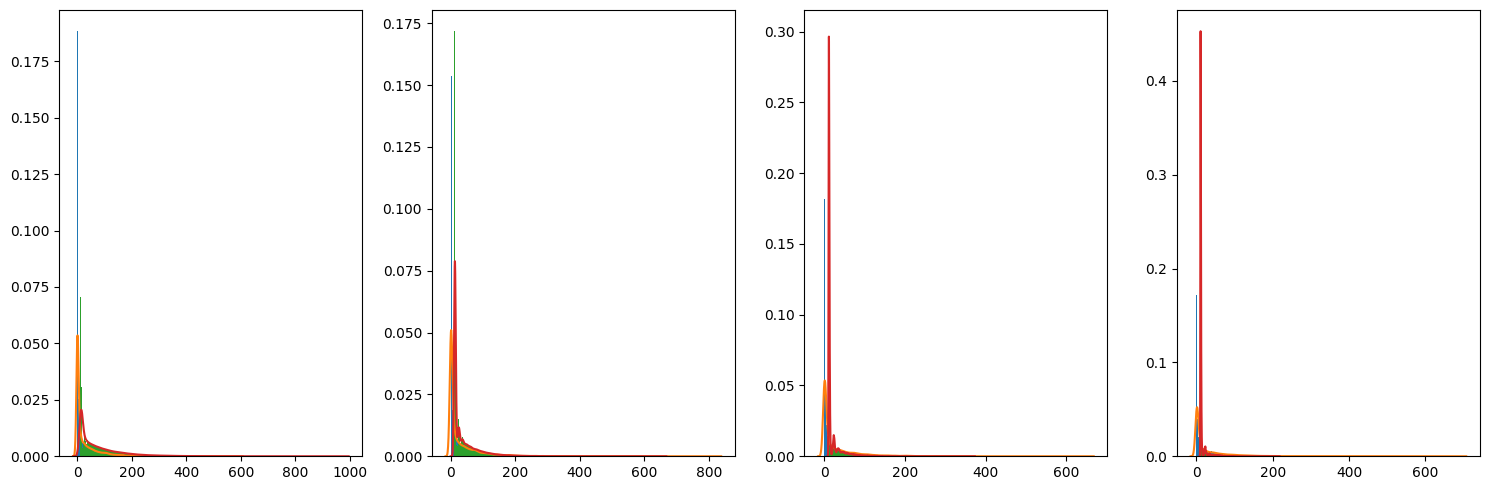

In [36]:
"""
    run_randomised_experiment(::T, l, L, dt, N, θs) where T <: ContinuousTimeProcess

Sample first passage times for a diffusion with law of type `T` with parameters
drawn at random from a Markov chain of parameters `θs`---effectively, this
function performs sampling of first passage times from diffusion laws, whose
parameter is integrated against its posterior distribution.
"""
function run_randomised_experiment(::T, l, L, dt, N, θs) where T <: ContinuousTimeProcess
    num_samples = length(θs)
    quarter_θs = div(num_samples, 4)
    θs_to_sample = θs[quarter_θs:end]
    samples = zeros(Float64, N)
    for i in 1:N
        P = T(rand(θs_to_sample)...)
        samples[i] = sampleFPT(0.0, l, L, dt, P)
    end
    samples
end


τ_parameters = (
    P = P,
    l = Xτs[1][1],
    L = Xτs[1][2],
    dt = 0.01,
    num_samples = Int64(1e4),
    θs = θs,
)

τs_OU = map([6.0, 8.25, 10.5, 12.75]) do I_t
    current(t, ::OrnsteinUhlenbeck) = I_t
    run_randomised_experiment(τ_parameters...)
end

axs = plot_many_τ_hist(τs_OU)
plot_many_τ_hist(τs_HH, nbins=600, ax=axs)
plt.show()

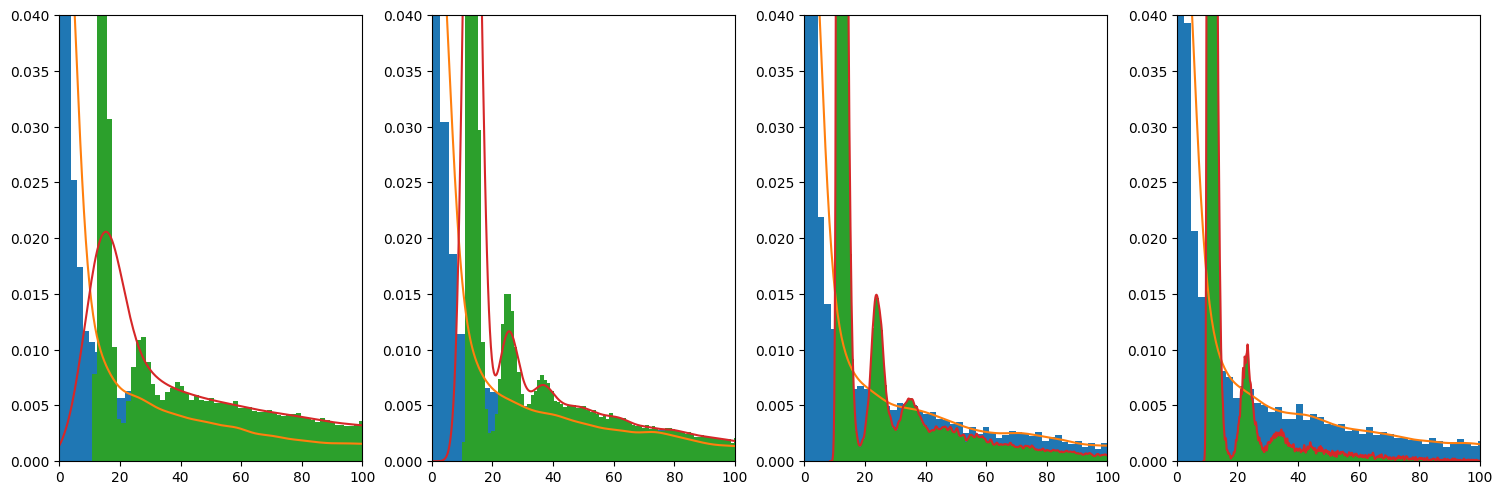

In [38]:
axs = plot_many_τ_hist(τs_OU)
plot_many_τ_hist(τs_HH, nbins=600, ax=axs)
# zoom-in
for ax in axs ax.set_ylim([0.0, 0.04]) end
for ax in axs ax.set_xlim([0, 100]) end
plt.show()

Not very well, I would say.

# Cox-Ingersoll Ross process
How about Cox-Ingersoll Ross process? We assume that the underlying process follows the dynamics given by the stochastic differential equation:

$$
dX_t = [\alpha - \theta(X_t-\nu) + I_t]dt + \sigma\sqrt{X_t-\nu}dW_t,\quad t\in[0,T],\quad X_0=x_0,
$$

where $\nu$ is an offset, shifting the $0$ on the $y$-axis (because we are assuming that the reset and threshold and known and fixed). Let's run the inference. **Note** that we are using very strong priors on $\nu$, as otherwise the inference does not work.

In [37]:
#******************************************************************************#
#------------------------------------------------------------------------------#
#                        Run inference on CIR process
#------------------------------------------------------------------------------#
#******************************************************************************#
Random.seed!(5)
current(t, ::CoxIngersollRoss) = (
    6.0 +
    2.25 * (t <= cumulative_trial_lengths[3]) +
    2.25 * (t <= cumulative_trial_lengths[2]) +
    2.25 * (t <= cumulative_trial_lengths[1])
)
current_prime(t, ::CoxIngersollRoss) = 0.0

# θ = [0.3, 1.5, -80.0, 1.2]
θ = [0.4, 1.0, -20.0, 1.0]
P = CoxIngersollRoss(θ...)
parameters = (
    P = P,
    dt = 0.1,
    num_mcmc_steps = 1000,
    ρ = 0.95,
    updt_param_idx = [1, 2, 3, 4],
    t_kernel = CIRRandomWalk([0.2, 0.2, 1.0, 0.1]),
    priors = (
        ImproperPosPrior(),
        ImproperPrior(),
        NormalPrior(Xτs[1][1], 1.0),
        #BackExp(10.0, Xτs[1][1]),
        ImproperPosPrior(),
    ),
    update_type = (
        MetropolisHastings(),
        MetropolisHastings(),
        MetropolisHastings(),
        MetropolisHastings(),
    ),
    save_iter = 100,
    verb_iter = 100,
)

(θs_CIR, paths_CIR, estim_θ_CIR), elapsed = @timeit mcmc(τs, Xτs, parameters...)


* * *
Updating ρs...
[1], ar: 0.11, ρ: 0.95; [2], ar: 0.14, ρ: 0.95; [3], ar: 0.28, ρ: 0.95; [4], ar: 0.16, ρ: 0.95; [5], ar: 0.27, ρ: 0.95; ... (30 ρs are not displayed) ...[36], ar: 0.76, ρ: 0.95; [37], ar: 0.67, ρ: 0.95; [38], ar: 0.6, ρ: 0.95; [39], ar: 0.79, ρ: 0.95; [40], ar: 0.71, ρ: 0.95; 
------------
New ρs: 
[1], ρ: 0.955; [2], ρ: 0.955; [3], ρ: 0.945; [4], ρ: 0.955; [5], ρ: 0.945; ... (30 ρs are not displayed) ...[36], ρ: 0.945; [37], ρ: 0.945; [38], ρ: 0.945; [39], ρ: 0.945; [40], ρ: 0.945; 
------------

it: 100, llᵒ: -520.219, ll: -515.4, llr: -4.879
* * *
Updating ρs...
[1], ar: 0.04, ρ: 0.955; [2], ar: 0.05, ρ: 0.955; [3], ar: 0.21, ρ: 0.945; [4], ar: 0.01, ρ: 0.955; [5], ar: 0.14, ρ: 0.945; ... (30 ρs are not displayed) ...[36], ar: 0.74, ρ: 0.945; [37], ar: 0.78, ρ: 0.945; [38], ar: 0.6, ρ: 0.945; [39], ar: 0.65, ρ: 0.945; [40], ar: 0.69, ρ: 0.945; 
------------
New ρs: 
[1], ρ: 0.959; [2], ρ: 0.959; [3], ρ: 0.95; [4], ρ: 0.959; [5], ρ: 0.95; ... (30 ρs are not displ

(output = (Array{Float64,1}[[0.4, 1.0, -20.0, 1.0], [0.4, 1.0, -20.0, 1.0], [0.4, 1.0, -20.0, 1.0], [0.4, 1.0, -20.0, 1.0], [0.4, 1.0, -20.0, 0.9216395301872198], [0.4, 1.0, -20.0, 0.9216395301872198], [0.4, 0.8232061045879895, -20.0, 0.9216395301872198], [0.4, 0.8232061045879895, -20.0, 0.9216395301872198], [0.4, 0.8232061045879895, -20.0, 0.8886004251151417], [0.4, 0.8232061045879895, -20.0, 0.8886004251151417]  …  [0.5586156868621884, 0.8605453995791419, -24.48447601570959, 1.0002558833401167], [0.5586156868621884, 0.8605453995791419, -24.48447601570959, 1.0002558833401167], [0.5586156868621884, 0.8605453995791419, -24.48447601570959, 1.0002558833401167], [0.5586156868621884, 0.8605453995791419, -24.48447601570959, 1.0002558833401167], [0.5586156868621884, 0.8605453995791419, -24.48447601570959, 1.0002558833401167], [0.5586156868621884, 0.8605453995791419, -24.48447601570959, 1.0002558833401167], [0.5586156868621884, 0.8605453995791419, -24.48447601570959, 1.0002558833401167], [0.55

And examine the results...

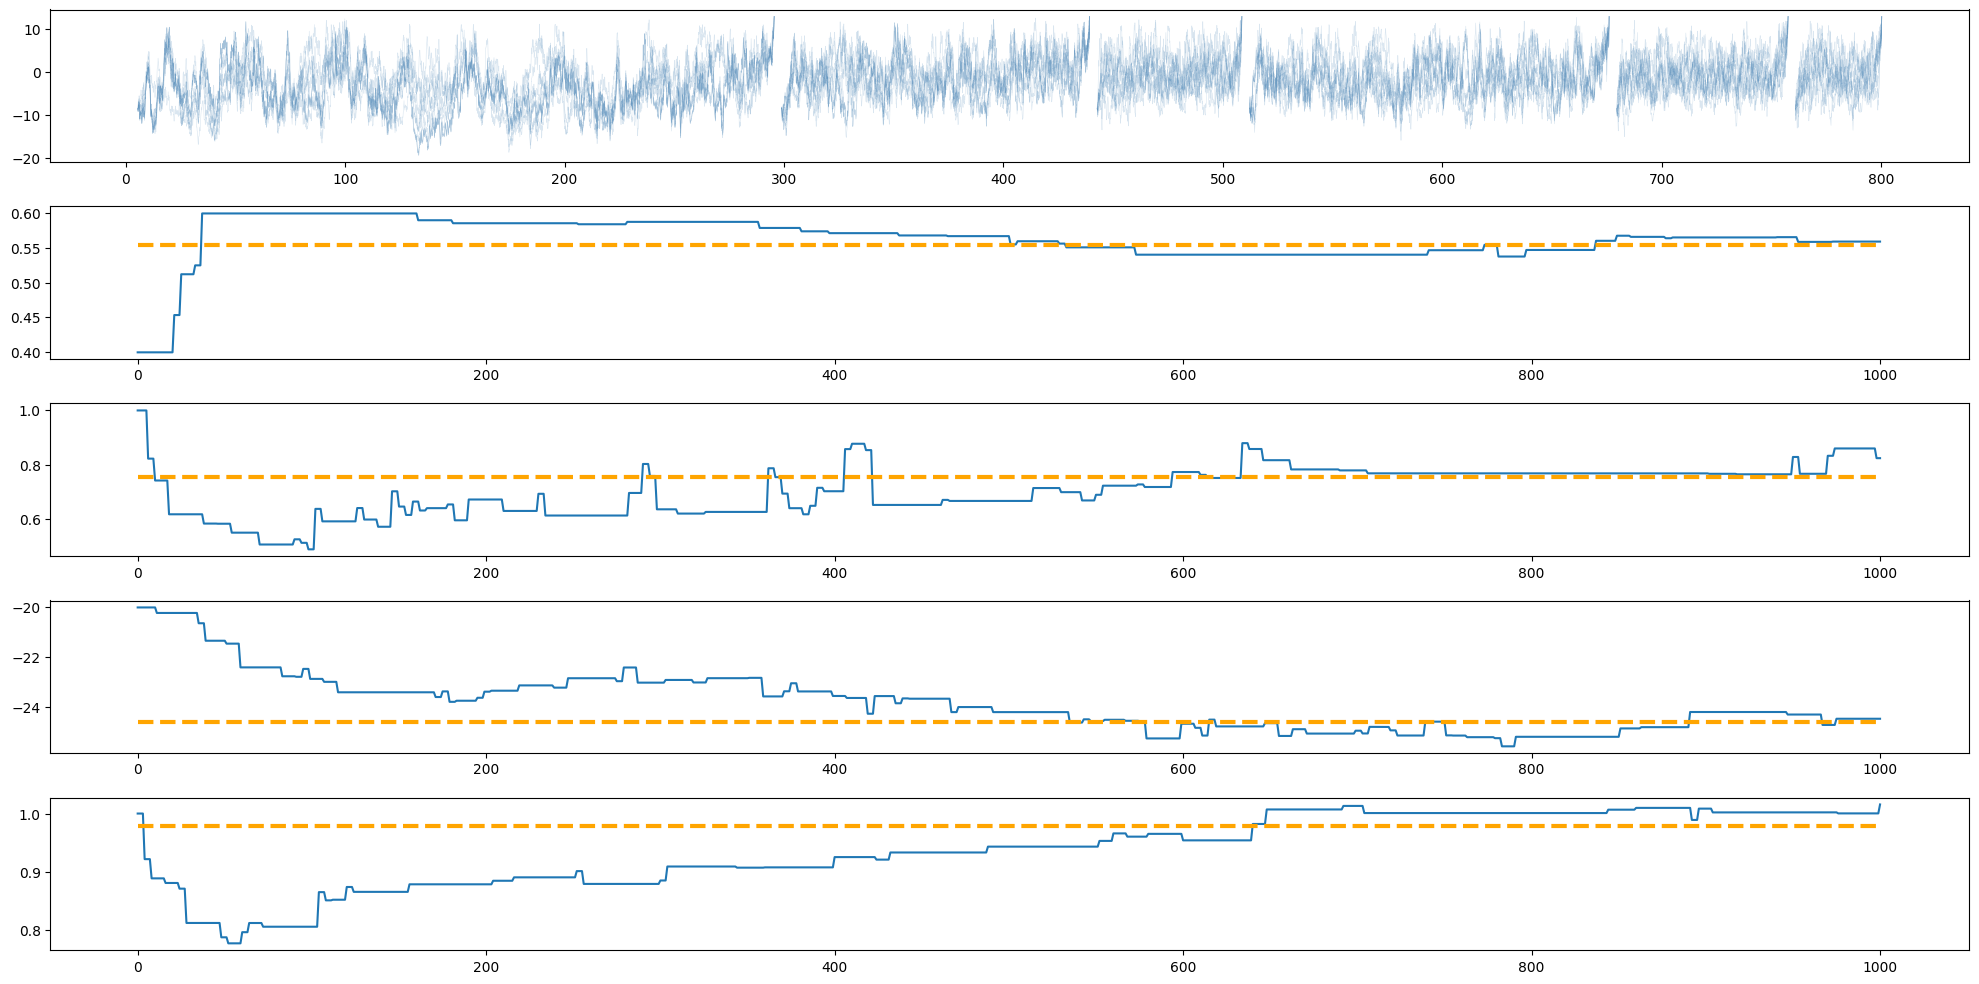

In [39]:
#------------------------------------------------------------------------------#
#                                   SUMMARY
#------------------------------------------------------------------------------#
ax = standard_summary_plot(P, paths_CIR, θs_CIR, estim_θ_CIR)
plt.show()

In [ ]:
τ_parameters = (
    P = P,
    l = Xτs[1][1],
    L = Xτs[1][2],
    dt = 0.01,
    num_samples = Int64(1e4),
    θs = θs_CIR,
)

state_space(P::CoxIngersollRoss) = MustBeAbove(P.low) #NOTE this is an ad-hoc change that will have to be dealt with better in the code later on...

τs_CIR = map([6.0, 8.25, 10.5, 12.75]) do I_t
    current(t, ::CoxIngersollRoss) = I_t
    run_randomised_experiment(τ_parameters...)
end

state_space(P::CoxIngersollRoss) = MustBePositive() # reverting

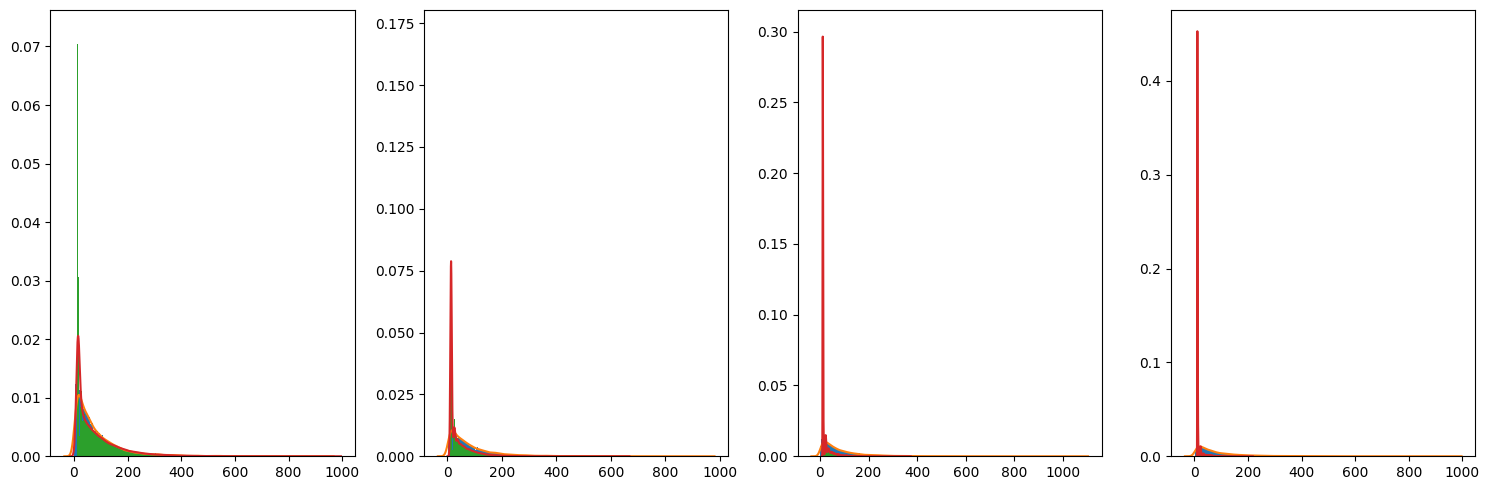

In [41]:
axs = plot_many_τ_hist(τs_CIR)
plot_many_τ_hist(τs_HH, nbins=600, ax=axs)
plt.show()

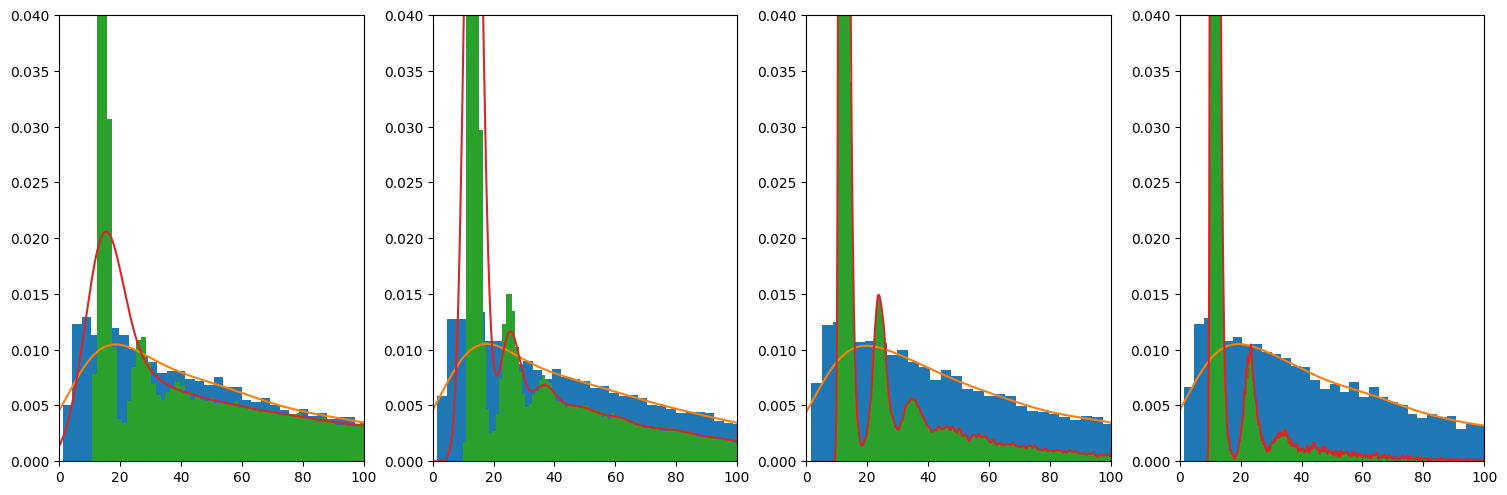

In [42]:
# and a zoom-in
axs = plot_many_τ_hist(τs_CIR)
plot_many_τ_hist(τs_HH, nbins=600, ax=axs)
# zoom-in
for ax in axs ax.set_ylim([0.0, 0.04]) end
for ax in axs ax.set_xlim([0, 100]) end
plt.show()